# Clusterização do Dataset IRIS com K-means e TensorFlow

*TF não é o melhor framework para esse tipo de clusterizacao, seria como matar uma formiga com uma bazuca. O objetivo desse arquivo é desenvolver um exercício de clustarização com K-means no TensorFlow*

*Até a construção dos códigos (mar/2020) não havia sido implementado o algoritmo K-means no tf 2.x*
*Dessa forma, é utilizado tf 2.x com funções adaptadas do tf 1.x*

In [1]:
# Carregar pacotes
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import datasets
from scipy.spatial import cKDTree
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

from tensorflow.python.framework import ops
ops.reset_default_graph()

In [2]:
# Essa linha de código desabilita o Eager Execution e permite a inicialização de variáveis na sessão, recurso do TF 1.x
tf.compat.v1.disable_eager_execution()

# Sessão
sess = tf.compat.v1.Session()

In [3]:
# Carregar o dataset
iris = datasets.load_iris()

In [4]:
# Definir caracteristicas dos dados
num_pts = len(iris.data)
num_feats = len(iris.data[0])

In [5]:
# Parâmetros do K-means
k = 3 # existem 3 tipos de flores no dataset
generations = 30

In [6]:
# Variáveis (seerão carregadas quando executarmos a sessão) - caracteristica do tf 1.x
data_points = tf.Variable(iris.data)
cluster_labels = tf.Variable(tf.zeros([num_pts], dtype = tf.int64))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [7]:
# Escolher randomicamente os pontos de dados e os centróides
rand_starts = np.array([iris.data[np.random.choice(len(iris.data))] for _ in range(k)])
centroids = tf.Variable(rand_starts)

In [8]:
# Calcular as distâncias entre cada um dos pontos de dados e cada um dos centróides
centroid_matrix = tf.reshape(tf.tile(centroids, [num_pts, 1]), [num_pts, k, num_feats])

In [9]:
# Remodelar os pontos de dados em 3 (k) repetições
point_matrix = tf.reshape(tf.tile(data_points, [1, k]), [num_pts, k, num_feats])
distances = tf.reduce_sum(input_tensor = tf.square(point_matrix - centroid_matrix), axis = 2)

In [10]:
# Centróide mais próximo - menor distância - para cara ponto de dados
centroid_group = tf.argmin(input=distances, axis=1)

In [11]:
# Definir função que encontra a média do grupo para obter um novo centróide (aumentar precisão)
def data_group_avg(group_ids, data):
    # Soma cada grupo
    sum_total = tf.math.unsorted_segment_sum(data, group_ids, 3)
    # Conta cada grupo
    num_total = tf.math.unsorted_segment_sum(tf.ones_like(data), group_ids, 3)
    # Calcula a média
    avg_by_group = sum_total/num_total
    return(avg_by_group)

In [12]:
# Média
means = data_group_avg(centroid_group, data_points)

# Atualiza os centóides
update = tf.group(centroids.assign(means), cluster_labels.assign(centroid_group))

# Inicializa as variáveis
init = tf.compat.v1.global_variables_initializer()

In [13]:
# Executa a sessãos
sess.run(init)

In [14]:
# Criar o modelo
for i in range(generations):
    _, centroid_group_count = sess.run([update, centroid_group])
    group_count = []
    for ix in range(k):
        group_count.append(np.sum(centroid_group_count==ix))
    

[centers, assignments] = sess.run([centroids, cluster_labels])

In [15]:
# Definir função para encontrar elemento mais comum 
def most_common(my_list):
    return(max(set(my_list), key = my_list.count))

In [16]:
# Encontrar quais atribuições de grupo correspondem a quais rótulos de grupo
label0 = most_common(list(assignments[0:50]))
label1 = most_common(list(assignments[50:100]))
label2 = most_common(list(assignments[100:150]))

group0_count = np.sum(assignments[0:50]==label0)
group1_count = np.sum(assignments[50:100]==label1)
group2_count = np.sum(assignments[100:150]==label2)

accuracy = (group0_count + group1_count + group2_count)/150.

print('Acurácia: {:.2}'.format(accuracy))

Acurácia: 0.89


# Visualização do Modelo

In [17]:
# Transformar 4 dimensoes em 2 com técnica PCA
pca_model = PCA(n_components = 2)
reduced_data = pca_model.fit_transform(iris.data)

# Transformar centros
reduced_centers = pca_model.transform(centers)

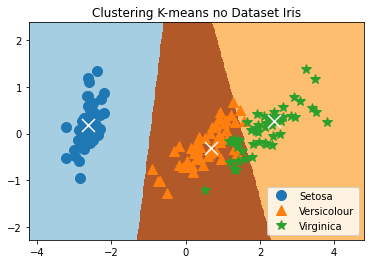

In [19]:
# Plot

# Step size do mesh plotting
h = .02

# Traçar o limite de decisão. Para isso, atribuiremos uma cor a cada k.
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obter k-means classificações para os pontos de grade
xx_pt = list(xx.ravel())
yy_pt = list(yy.ravel())
xy_pts = np.array([[x,y] for x,y in zip(xx_pt, yy_pt)])
mytree = cKDTree(reduced_centers)
dist, indexes = mytree.query(xy_pts)

# Coloque o resultado em um gráfico de cores
indexes = indexes.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(indexes, interpolation = 'nearest', extent = (xx.min(), xx.max(), yy.min(), yy.max()), cmap = plt.cm.Paired, aspect = 'auto', origin = 'lower')

# Traçar cada um dos grupos de dados da íris verdadeira
symbols = ['o', '^', '*']
label_name = ['Setosa', 'Versicolour', 'Virginica']
for i in range(3):
    temp_group = reduced_data[(i*50):(50)*(i+1)]
    plt.plot(temp_group[:, 0], temp_group[:, 1], symbols[i], markersize = 10, label = label_name[i])

# Traçar os centróides como um X branco
plt.scatter(reduced_centers[:, 0], reduced_centers[:, 1], marker = 'x', s = 169, linewidths = 3, color = 'w', zorder = 10)
plt.title('Clustering K-means no Dataset Iris')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.legend(loc = 'lower right')
plt.show()